# Ejercicio aplicado_Predicción de series temporales con modelos avanzados de LSTM

A continuación vamos a entrenar un modelo de LSTM para predecir el número de pasajeros de avión. Código basado en https://github.com/gianfelton/ 

### Importación de librerías y datos

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('AirPassengers.csv')

In [70]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

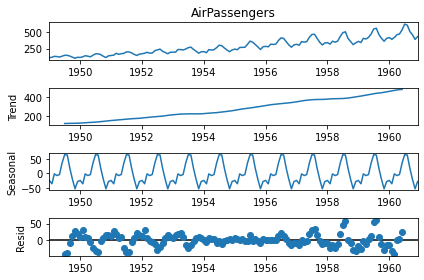

In [71]:
a = seasonal_decompose(df.AirPassengers, model = "add")
a.plot();

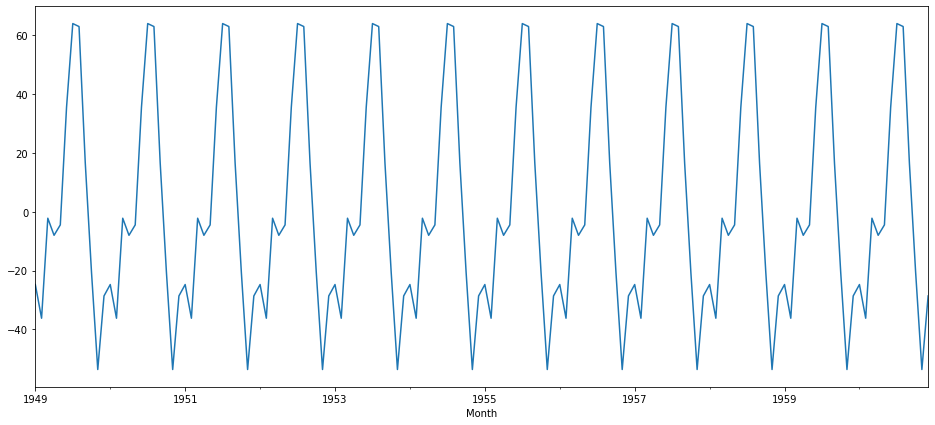

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

### Pre-procesamiento de datos

In [73]:
train, test = df[:-12], df[-12:]

In [74]:
train_original = train.copy()
test_original = test.copy()

In [75]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [76]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=6)

In [77]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu',return_sequences=True,
                    input_shape=(n_input, n_features)))

lstm_model.add(LSTM(100, return_sequences=True))
lstm_model.add(Dropout(rate=0.2))

lstm_model.add(LSTM(300, return_sequences=False))
lstm_model.add(Dense(1))

mc = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', mode='min', 
                     verbose=1, save_best_only=True)

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 12, 100)           40800     
_________________________________________________________________
lstm_10 (LSTM)               (None, 12, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 100)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 300)               481200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 602,701
Trainable params: 602,701
Non-trainable params: 0
_________________________________________________________________


In [78]:
lstm_model.compile(optimizer='adam', 
              loss='mse')

### EarlyStopping y Validation Generator

In [79]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           patience=18)

In [82]:
validation_generator = TimeseriesGenerator(test_scaled,test_scaled, 
                                           length=n_input-1)

In [83]:
# fit model
lstm_model.fit_generator(generator,epochs=40,
                    validation_data=validation_generator,
                   callbacks=[early_stop, mc])

Epoch 1/40
20/20 [==============================] - 1s 25ms/step - loss: 0.0069 - val_loss: 0.0305

Epoch 00001: val_loss improved from 0.04103 to 0.03053, saving model to best_model_lstm.h5
Epoch 2/40
20/20 [==============================] - 1s 25ms/step - loss: 0.0083 - val_loss: 0.0269

Epoch 00002: val_loss improved from 0.03053 to 0.02692, saving model to best_model_lstm.h5
Epoch 3/40
20/20 [==============================] - 1s 25ms/step - loss: 0.0092 - val_loss: 3.7047e-04

Epoch 00003: val_loss improved from 0.02692 to 0.00037, saving model to best_model_lstm.h5
Epoch 4/40
20/20 [==============================] - 1s 25ms/step - loss: 0.0057 - val_loss: 9.8796e-04

Epoch 00004: val_loss did not improve from 0.00037
Epoch 5/40
20/20 [==============================] - 0s 22ms/step - loss: 0.0051 - val_loss: 4.2653e-04

Epoch 00005: val_loss did not improve from 0.00037
Epoch 6/40
20/20 [==============================] - 1s 25ms/step - loss: 0.0059 - val_loss: 3.1347e-06

Epoch 000

<AxesSubplot:>

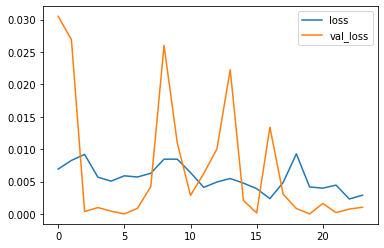

In [84]:
losses = pd.DataFrame(lstm_model.history.history)
losses.plot()

### Predicción de 12 meses

A continuación vamos a realizar una predicción para 12 meses (12 predicciones). Para ello vamos a hacer los siguiente:
- crear una lista vacía para cada una de nuestras 12 predicciones
- crear el lote que nuestro modelo predecirá 
- guardar la predicción en nuestra lista
- agregar la predicción al final del lote para usarla en la próxima predicción

In [85]:
pred_list = []

batch = train_scaled[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input): 
    
     # get prediction 1 time stamp ahead 
    pred_list.append(lstm_model.predict(batch)[0]) 
    
    # update batch to now include prediction and drop first value
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

#### Invertir la transformación

In [86]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

In [87]:
df_test = pd.concat([test,df_predict], axis=1)

In [89]:
df_predict.size

12

No handles with labels found to put in legend.


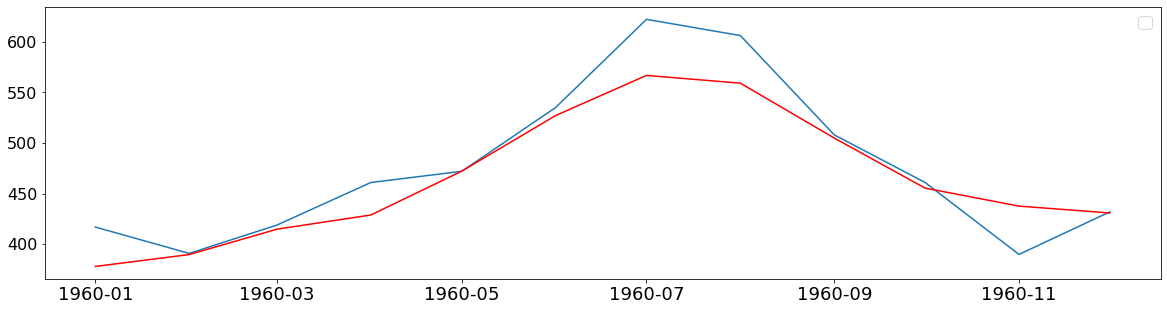

In [90]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['AirPassengers'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [91]:
lstm_rmse_error = rmse(df_test['AirPassengers'], df_test["Prediction"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['AirPassengers'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 850.4880752013282
RMSE Error: 29.163128693631762
Mean: 280.2986111111111


### Reentrenar y predecir nuevos datos

In [56]:
train = df

In [57]:
scaler.fit(train)
train = scaler.transform(train)

In [58]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [59]:
lstm_model.fit_generator(generator,epochs=90)

Epoch 1/90
22/22 [==============================] - 1s 25ms/step - loss: 0.0133
Epoch 2/90
22/22 [==============================] - 1s 23ms/step - loss: 0.0080
Epoch 3/90
22/22 [==============================] - 0s 22ms/step - loss: 0.0060
Epoch 4/90
22/22 [==============================] - 1s 23ms/step - loss: 0.0058
Epoch 5/90
22/22 [==============================] - 1s 23ms/step - loss: 0.0063
Epoch 6/90
22/22 [==============================] - 1s 24ms/step - loss: 0.0049
Epoch 7/90
22/22 [==============================] - 0s 22ms/step - loss: 0.0045
Epoch 8/90
22/22 [==============================] - 0s 21ms/step - loss: 0.0104
Epoch 9/90
22/22 [==============================] - 1s 23ms/step - loss: 0.0079
Epoch 10/90
22/22 [==============================] - 1s 23ms/step - loss: 0.0044
Epoch 11/90
22/22 [==============================] - 1s 31ms/step - loss: 0.0062
Epoch 12/90
22/22 [==============================] - 1s 25ms/step - loss: 0.0034
Epoch 13/90
22/22 [==================

In [60]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(lstm_model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [61]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [62]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

No handles with labels found to put in legend.


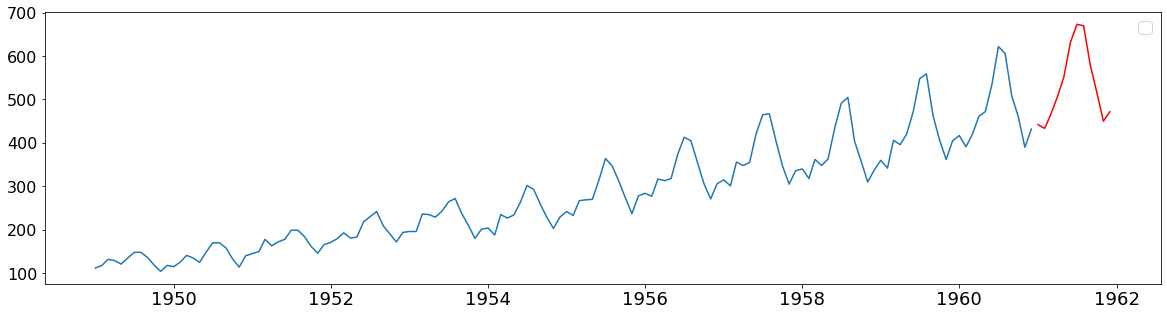

In [63]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['AirPassengers'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()